In [1]:
from trainer.networks.network3d import CNN_240p_Denoiser_3d
from trainer.data import load_data
import torch
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from inputimeout import inputimeout, TimeoutOccurred
from trainer.utils import *

2023-10-04 05:39:37.814888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 05:39:37.814944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 05:39:37.814986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 05:39:37.825506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 05:39:38.907313: W tensorflow/compiler/

In [2]:
def load_model_from_path( path, device):
    model_name = path
    network = load_model(model_type=CNN_240p_Denoiser_3d, model_name=model_name)
    network.to(device)
    return network

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
network = load_model_from_path(f'/workspace/experiments/cnn_240p_den_v_3dCNN_MSE_DepthPoint_16bs_0', device) 

In [5]:
loss = torch.nn.MSELoss()

In [6]:
val_data = load_data(os.path.join('/workspace/CNN_240p_Denoiser', 'val'), batch_size=8, num_workers=10, num_dataset_threads=1, data_count=2000)

Loading /workspace/CNN_240p_Denoiser/val on 1 threads
Thread started


CNN_240p_Denoiser-val-(0, 2000): 100%|██████████| 2000/2000 [00:01<00:00, 1101.64it/s, image=['CNN_SD_Denoiser-albedo-999.jpg', 'CNN_SD_Denoiser-converged-999.jpg', 'CNN_SD_Denoiser-depth-999.jpg', 'CNN_SD_Denoiser-emission-999.jpg', 'CNN_SD_Denoiser-noisy-999.jpg', 'CNN_SD_Denoiser-normals-999.jpg', 'CNN_SD_Denoiser-shape-999.jpg', 'CNN_SD_Denoiser-specular-999.jpg']]        


In [7]:
def validate(network, val_data, device, loss):
        total_val_loss = 0
        network.eval()
        debug_images = []
        with tqdm(iter(val_data), unit="batches") as valloop:
            for i, buffers in enumerate(valloop):
                # self.loss_plotter.update_display()
                valloop.set_description(f"Val Batch {i}")
                input_tensor = network.make_input_tensor(
                                noisy=buffers['noisy'],
                                normals=buffers['normals'],
                                depth=buffers['depth'],
                                albedo=buffers['albedo'],
                                shape=buffers['shape'],
                                emission=buffers['emission'],
                                specular=buffers['specular'],
                            ).to(device)
                ground_truth = buffers['converged'][:, :, None, :, :].to(device)
                res = network(input_tensor)
                if (i == 0):
                    debug_images.append((input_tensor[:8, :, 0, :, :], ground_truth[:8, :, 0, :, :], res[:8, :, 0, :, :]))
                    pass
                input_tensor = input_tensor.detach()
                del input_tensor
                l = loss(res, ground_truth)
                ground_truth = ground_truth.detach()
                del ground_truth
                curr_loss = l.cpu().data
                total_val_loss += curr_loss
                valloop.set_postfix(loss=f"{curr_loss}")
        return total_val_loss / len(val_data.dataset), debug_images

In [8]:
loss, debug_images = validate(network, val_data, device, loss)

Val Batch 249: 100%|██████████| 250/250 [00:27<00:00,  9.09batches/s, loss=0.010658718645572662] 


In [9]:
import torchvision
def show_images(res):
    grid_img = torchvision.utils.make_grid(res, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))

In [10]:
def record_imgs(noisy, tru, pred):
    assert len(tru.shape) == 4
    assert tru.shape == pred.shape
    final = torch.zeros(3 * tru.shape[0], tru.shape[1], tru.shape[2], tru.shape[3])
    j = 0
    for i in range(tru.shape[0]):
        final[j] = noisy[i]
        final[j+1] = tru[i]
        final[j+2] = pred[i]
        j += 3
    return final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([24, 3, 240, 426])


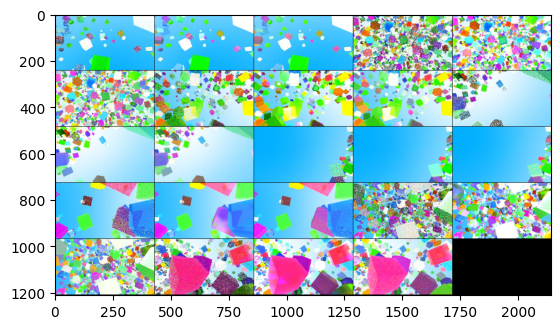

In [11]:
recorded_images = record_imgs(debug_images[0][0].detach().cpu(), debug_images[0][1].detach().cpu(), debug_images[0][2].detach().cpu())
print(recorded_images.shape)

show_images(recorded_images)